In [1]:
import gzip
from collections import defaultdict

## Helpfulness baseline 
### Compute the global average helpfulness rate, and the average helpfulness rate for each user

In [2]:
def readGz(f):
  for l in gzip.open(f):
    yield eval(l)

allHelpful = []
userHelpful = defaultdict(list)

for l in readGz("train.json.gz"):
  user,item = l['reviewerID'],l['itemID']
  allHelpful.append(l['helpful'])
  userHelpful[user].append(l['helpful'])

averageRate = sum([x['nHelpful'] for x in allHelpful]) * 1.0 / sum([x['outOf'] for x in allHelpful])
userRate = {}
for u in userHelpful:
  totalU = sum([x['outOf'] for x in userHelpful[u]])
  if totalU > 0:
    userRate[u] = sum([x['nHelpful'] for x in userHelpful[u]]) * 1.0 / totalU
  else:
    userRate[u] = averageRate

predictions = open("predictions_Helpful.txt", 'w')
for l in open("pairs_Helpful.txt"):
  if l.startswith("userID"):
    #header
    predictions.write(l)
    continue
  u,i,outOf = l.strip().split('-')
  outOf = int(outOf)
  if u in userRate:
    predictions.write(u + '-' + i + '-' + str(outOf) + ',' + str(outOf*userRate[u]) + '\n')
  else:
    predictions.write(u + '-' + i + '-' + str(outOf) + ',' + str(outOf*averageRate) + '\n')

predictions.close()

## For reading the files in a pandas Dataframe.

In [3]:
import pandas as pd
from collections import defaultdict

def readGz(f):
    for l in gzip.open(f):
        yield eval(l)

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('train.json.gz')
test_df = getDF('test_Helpful.json.gz')

In [4]:
df.shape

(200000, 12)

In [5]:
df.head()

,categoryID,categories,itemID,reviewerID,rating,reviewText,reviewHash,reviewTime,summary,unixReviewTime,helpful,price
0,0,"[[Clothing, Shoes & Jewelry, Women], [Clothing...",I655355328,U745881038,3.0,"These are cute, but they are a little small. ...",R115160670,"05 20, 2014",Cute,1400544000,"{'outOf': 0, 'nHelpful': 0}",NaN
1,0,"[[Clothing, Shoes & Jewelry, Women, Clothing, ...",I241092314,U023577405,4.0,"I love the look of this bra, it is what I want...",R800651687,"02 7, 2013",Beautiful but size runs small,1360195200,"{'outOf': 0, 'nHelpful': 0}",NaN
2,0,"[[Clothing, Shoes & Jewelry, Wedding Party Gif...",I408260822,U441384838,3.0,it's better on a man's hand.I didn't find it v...,R345042616,"05 13, 2014",Good price but...,1399939200,"{'outOf': 2, 'nHelpful': 2}",19.99
3,0,"[[Clothing, Shoes & Jewelry, Women, Clothing, ...",I770448753,U654041297,4.0,Comfortable and easy to wear for a day of shop...,R875466866,"05 25, 2014","Easy, breezy",1400976000,"{'outOf': 0, 'nHelpful': 0}",14.95
4,0,"[[Clothing, Shoes & Jewelry, Women, Plus-Size,...",I919238161,U096604734,5.0,I'm quite small and the XS fits me like a regu...,R317526520,"07 30, 2013",Great shirt,1375142400,"{'outOf': 1, 'nHelpful': 1}",NaN


## Training data exploration

### categoryID

In [6]:
# get the unique number of categories

print(set(df.categoryID))

{0, 1, 2, 3, 4}


### categories

In [7]:
# categories is an collection of buying categories or category labels inside a list

for i in df.categories[:3]:
    print(i)
    print('\n')

[['Clothing, Shoes & Jewelry', 'Women'], ['Clothing, Shoes & Jewelry', 'Novelty, Costumes & More', 'Novelty', 'Clothing', 'Women', 'Leggings']]


[['Clothing, Shoes & Jewelry', 'Women', 'Clothing', 'Lingerie, Sleep & Lounge', 'Intimates', 'Bras', 'Everyday Bras'], ['Clothing, Shoes & Jewelry', 'Women', 'Petite', 'Intimates', 'Bras', 'Everyday Bras']]


[['Clothing, Shoes & Jewelry', 'Wedding Party Gifts', 'Gifts for the Groomsmen'], ['Clothing, Shoes & Jewelry', 'Women'], ['Clothing, Shoes & Jewelry', 'Novelty, Costumes & More', 'Novelty']]




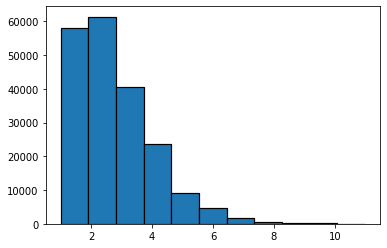

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}


In [8]:
# count the number of lists in each review

category_label_count = []
for i in df.categories:
    category_label_count.append(len(i))
    
# plot histogram
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

num_bins = 11
n, bins, patches = plt.hist(category_label_count, num_bins, linewidth=1.2, edgecolor='black')
plt.show()

print(set(category_label_count))

In [9]:
# find all category lists

categories_list = []
for i in df.categories:
    for j in i:
        categories_list.append(tuple(j))
        
len(set(categories_list))

1847

In [33]:
# get unique category lists
categories_list = []
for i in df.categories:
    for j in i:
        categories_list.append(tuple(j))
        
# make dictionary with IDs
categorylists_dict = {k:v for v,k in enumerate(set(categories_list))}

# transform list occurance to numbers using dictionary 
category_numtrans = []
for i in df.categories:
    sum_ = 0
    for j in i:
        sum_ += categorylists_dict[tuple(j)]
    category_numtrans.append(sum_)
    
# add feature to df

In [37]:
max(category_numtrans)

11342

In [ ]:
df.shape

In [12]:
categories_list

[('Clothing, Shoes & Jewelry', 'Women'),
 ('Clothing, Shoes & Jewelry',
  'Novelty, Costumes & More',
  'Novelty',
  'Clothing',
  'Women',
  'Leggings'),
 ('Clothing, Shoes & Jewelry',
  'Women',
  'Clothing',
  'Lingerie, Sleep & Lounge',
  'Intimates',
  'Bras',
  'Everyday Bras'),
 ('Clothing, Shoes & Jewelry',
  'Women',
  'Petite',
  'Intimates',
  'Bras',
  'Everyday Bras'),
 ('Clothing, Shoes & Jewelry',
  'Wedding Party Gifts',
  'Gifts for the Groomsmen'),
 ('Clothing, Shoes & Jewelry', 'Women'),
 ('Clothing, Shoes & Jewelry', 'Novelty, Costumes & More', 'Novelty'),
 ('Clothing, Shoes & Jewelry', 'Women', 'Clothing', 'Skirts', 'Casual'),
 ('Clothing, Shoes & Jewelry',
  'Women',
  'Plus-Size',
  'Tops & Tees',
  'Knits & Tees'),
 ('Clothing, Shoes & Jewelry',
  'Novelty, Costumes & More',
  'Novelty',
  'Clothing',
  'Women',
  'Tops & Tees',
  'T-Shirts'),
 ('Clothing, Shoes & Jewelry',
  'Novelty, Costumes & More',
  'Band & Music Fan',
  'T-Shirts'),
 ('Clothing, Shoes & J

In [10]:
# find number of times each category list appears

categories_list_count = {i:0 for i in set(categories_list)}

for i in categories_list:
    categories_list_count[i]+=1
        
{k: v for k, v in sorted(categories_list_count.items(), key=lambda item: item[1], reverse=True)}

{('Clothing, Shoes & Jewelry',
  'Shoes & Accessories: International Shipping Available'): 42579,
 ('Clothing, Shoes & Jewelry', 'Women'): 19111,
 ('Clothing, Shoes & Jewelry', 'Comfort Shoes'): 15084,
 ('Clothing, Shoes & Jewelry', 'Novelty, Costumes & More', 'Novelty'): 10496,
 ('Clothing, Shoes & Jewelry', 'Women', 'Shoes', 'Sandals'): 10417,
 ('Clothing, Shoes & Jewelry', 'Men', 'Big & Tall'): 9418,
 ('Clothing, Shoes & Jewelry',
  'Jewelry: International Shipping Available'): 9039,
 ('Clothing, Shoes & Jewelry', 'Women', 'Shoes', 'Boots'): 7676,
 ('Clothing, Shoes & Jewelry',
  'Women',
  'Clothing',
  'Lingerie, Sleep & Lounge',
  'Intimates',
  'Bras',
  'Everyday Bras'): 6659,
 ('Clothing, Shoes & Jewelry',
  'Women',
  'Clothing',
  'Tops & Tees',
  'Blouses & Button-Down Shirts'): 5489,
 ('Clothing, Shoes & Jewelry', 'Amazon Curated Collection'): 4832,
 ('Clothing, Shoes & Jewelry', 'Women', 'Shoes', 'Flats'): 4204,
 ('Clothing, Shoes & Jewelry', 'Women', 'Plus-Size'): 4144,


In [11]:
# find all unique individual categories inside the lists

import itertools
merged = list(itertools.chain.from_iterable(df.categories))
merged2 = list(itertools.chain.from_iterable(merged))

len(set(merged2))

1042

In [12]:
print(sorted(set(merged2)))

['0-9', '7 For All Mankind', 'ACORN', 'ASICS', 'Accessories', 'Action Sports', 'Active', 'Active & Performance', 'Active Base Layers', 'Active Dresses', 'Active Hoodies', 'Active Leggings', 'Active Pants', 'Active Shirts & Tees', 'Active Shorts', 'Active Skirts', 'Active Skorts', 'Active Sweatshirts', 'Active Top & Bottom Sets', 'Active Underwear', 'Active Vests', 'Adhesive Bras', 'Aerosoles', 'Aetrex', 'Allen Edmonds', 'Amazon Curated Collection', 'AmeriBag', 'Angel', 'Anklets', 'Anne Klein', 'Annie', 'Anniversary Rings', 'Anoraks', 'Antique & Estate Jewelry', 'Anuschka', 'Aprons', 'Ariat', 'Arm Warmers', 'Armitron', 'Armwarmers', 'Arts, Crafts & Sewing', 'Athena Alexander', 'Athletic', 'Athletic & Outdoor', 'Athletic Socks', 'Athletic Supporters', 'Automotive', 'Available for International Shipping', 'Avia', 'B', 'B. MAKOWSKY', 'BC Footwear', 'BCBGeneration', 'BIG BUDDHA', 'BLOCH', 'BLVD', 'Baby', 'Baby & Toddler Toys', 'Baby Boys', 'Baby Dolls', 'Baby Girls', 'Baby Products', 'Babyd

### itemID

In [13]:
# find the number of different itemIDs
print(len(set(df.itemID)))

19913


In [14]:
# find number of times each itemID shows up
items_dict = {i:0 for i in set(df.itemID)}
for i in df.itemID:
    items_dict[i]+=1

{k: v for k, v in sorted(items_dict.items(), key=lambda item: item[1], reverse=True)}

{'I833319191': 238,
 'I977996549': 208,
 'I376341145': 196,
 'I297551242': 187,
 'I261571553': 180,
 'I849087567': 174,
 'I402257020': 167,
 'I098334555': 164,
 'I204803612': 163,
 'I108046320': 161,
 'I081058514': 158,
 'I042518718': 153,
 'I175065706': 151,
 'I465733649': 149,
 'I065774479': 148,
 'I009517885': 145,
 'I236765772': 143,
 'I254231819': 138,
 'I513750671': 137,
 'I340840676': 136,
 'I871220798': 135,
 'I079035835': 128,
 'I415604968': 128,
 'I382028701': 127,
 'I087216587': 126,
 'I791878851': 125,
 'I884568015': 124,
 'I889478309': 122,
 'I690295733': 120,
 'I725163414': 118,
 'I587889758': 118,
 'I481506154': 116,
 'I262899988': 114,
 'I510051931': 113,
 'I586582494': 112,
 'I249128071': 111,
 'I868957733': 111,
 'I456740478': 110,
 'I034451537': 110,
 'I141398110': 108,
 'I158475384': 108,
 'I396699099': 108,
 'I451379175': 108,
 'I293808760': 107,
 'I569557957': 107,
 'I966668485': 106,
 'I757804880': 106,
 'I358372777': 103,
 'I984586267': 102,
 'I552047410': 101,


### reviewerID

In [15]:
# find the number of different reviewers
print(len(set(df.reviewerID)))

39249


In [16]:
# find number of times each reviewerID shows up
items_dict = {i:0 for i in set(df.reviewerID)}
for i in df.reviewerID:
    items_dict[i]+=1

{k: v for k, v in sorted(items_dict.items(), key=lambda item: item[1], reverse=True)}

{'U938275047': 109,
 'U255878241': 60,
 'U688616616': 58,
 'U197452169': 49,
 'U190038285': 45,
 'U582600166': 45,
 'U309771174': 44,
 'U980329247': 44,
 'U078523952': 43,
 'U234944822': 43,
 'U481333290': 42,
 'U110585235': 41,
 'U052604462': 40,
 'U726479415': 40,
 'U080774244': 39,
 'U100860173': 39,
 'U544816448': 39,
 'U388529572': 37,
 'U576303514': 37,
 'U269484324': 36,
 'U679556042': 36,
 'U642378242': 36,
 'U727171613': 35,
 'U522725773': 35,
 'U447406189': 35,
 'U823750186': 34,
 'U795820582': 34,
 'U477056993': 34,
 'U968805875': 34,
 'U137955164': 34,
 'U567488030': 32,
 'U225399269': 32,
 'U128803310': 32,
 'U988776276': 31,
 'U725351876': 31,
 'U073292989': 31,
 'U624930037': 31,
 'U451120324': 31,
 'U685978758': 30,
 'U824328990': 30,
 'U505828319': 30,
 'U286833760': 30,
 'U920093386': 29,
 'U079202852': 29,
 'U932317086': 29,
 'U422861835': 29,
 'U837208624': 29,
 'U441615584': 29,
 'U162629754': 29,
 'U495605130': 28,
 'U771216017': 28,
 'U376274108': 28,
 'U70287710

### rating

In [17]:
set(df.rating)

{1.0, 2.0, 3.0, 4.0, 5.0}

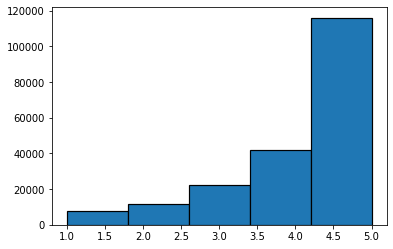

In [18]:
# plot histogram
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

num_bins = 5
n, bins, patches = plt.hist(df.rating, num_bins, linewidth=1.2, edgecolor='black')
plt.show()

### reviewText

In [19]:
# find length of text

reviewText_length = []
for i in df.reviewText:
    reviewText_length.append(len(i))
    
max(set(reviewText_length))

22646

In [40]:
# plot histogram for the number of characters
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy import stats
import string

num_bins = 2000
n, bins, patches = plt.hist(reviewText_length, num_bins)
print(stats.describe(reviewText_length))
plt.show()

NameError: name 'reviewText_length' is not defined

In [21]:
# sentiment analysis for positive and negative words in the review text

# import positive and negative word lists
posWords_list = [x.strip() for x in open("positive-words.txt", "r").readlines()]
negWords_list = [x.strip() for x in open("negative-words.txt", "r", encoding="ISO-8859-1").readlines()]

# count the number of positive and negative words present in each review text
pos_neg_count = []
for k,i in zip(df.index,df.reviewText):
#     print(k)
    words = [n.lower().translate(str.maketrans('','',string.punctuation)) for n in i.split(' ')]
    pos_count = 0
    neg_count = 0
    for j in words:
        if j in posWords_list:
            pos_count+=1
        elif j in negWords_list:
            neg_count+=1
        else: 
            continue
    pos_neg_count.append((pos_count, neg_count))
    
# pos_neg_count

DescribeResult(nobs=200000, minmax=(0, 100), mean=4.1078, variance=10.77067301336507, skewness=3.200525623285995, kurtosis=27.81313512425856)


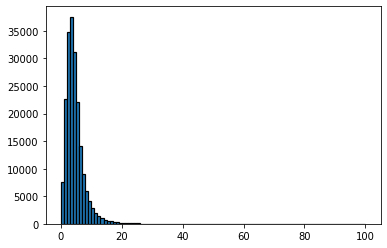

DescribeResult(nobs=200000, minmax=(0, 48), mean=1.112425, variance=3.0240707397286983, skewness=3.9267742438881785, kurtosis=34.571505439229696)


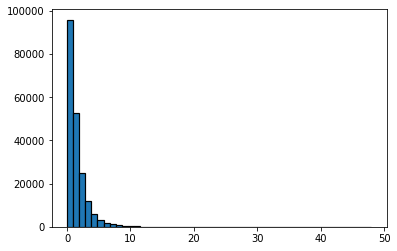

In [22]:
# see distribution of positive and negative word mentions

pos_count_list = [i[0] for i in pos_neg_count]
neg_count_list = [i[1] for i in pos_neg_count]

num_bins = 100
n, bins, patches = plt.hist(pos_count_list, num_bins, linewidth=1.2, edgecolor='black')
print(stats.describe(pos_count_list))
plt.show()

num_bins = 50
n, bins, patches = plt.hist(neg_count_list, num_bins, linewidth=1.2, edgecolor='black')
print(stats.describe(neg_count_list))
plt.show()

In [23]:
# find the positive and negative word rate

# count the number of words in each review
word_count = []
for i in df.reviewText:
    words = [n.lower().translate(str.maketrans('','',string.punctuation)) for n in i.split(' ')]
    words = [i for i in words if i != ''] # remove spaces
    word_count.append(len(words))

DescribeResult(nobs=200000, minmax=(0, 3856), mean=58.93828, variance=3485.170926496233, skewness=6.254921944251404, kurtosis=141.33906458359002)


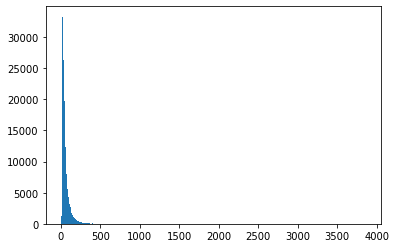

In [24]:
# see distribution of number of words for each review
num_bins = 100
n, bins, patches = plt.hist(word_count, num_bins)
print(stats.describe(word_count))
plt.show()

In [25]:
# find rate for pos and neg, assign zero when no words are present in review
# rate is defined as the number of pos or neg words divided by the total number of words for the review

pos_count_rate = [0 if j == 0 else i/j for i,j in zip(pos_count_list, word_count)]
print(stats.describe(pos_count_rate))
neg_count_rate = [0 if j == 0 else i/j for i,j in zip(neg_count_list, word_count)]
print(stats.describe(pos_count_rate))

DescribeResult(nobs=200000, minmax=(0.0, 1.0), mean=0.08629282282624753, variance=0.003535673246625973, skewness=2.578103379285913, kurtosis=21.971125151093993)
DescribeResult(nobs=200000, minmax=(0.0, 1.0), mean=0.08629282282624753, variance=0.003535673246625973, skewness=2.578103379285913, kurtosis=21.971125151093993)


### reviewHash

In [26]:
# find the number of different reviewHash
print(len(set(df.reviewHash)))

200000


### reviewTime

In [27]:
# find the number of different reviewTime
print(len(set(df.reviewTime)))

2532


In [28]:
df["reviewTime"] = df["reviewTime"].astype("datetime64")

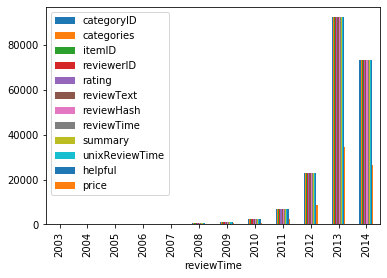

In [29]:
df.groupby(df["reviewTime"].dt.year).count().plot(kind="bar")

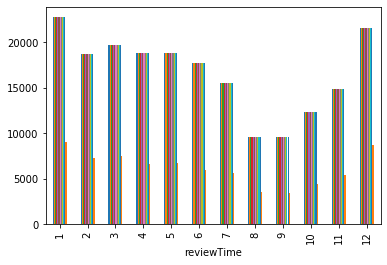

In [30]:
df.groupby(df["reviewTime"].dt.month).count().plot(kind="bar", legend=False)

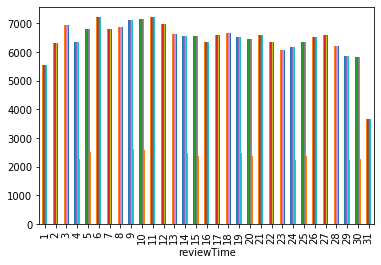

In [31]:
df.groupby(df["reviewTime"].dt.day).count().plot(kind="bar", legend=False)

### summary

In [32]:
# find length of text

summary_length = []
for i in df.summary:
    summary_length.append(len(i))
    
max(set(summary_length))

201

DescribeResult(nobs=200000, minmax=(1, 201), mean=20.198115, variance=193.64123365294327, skewness=1.956159950691418, kurtosis=6.318375497186986)


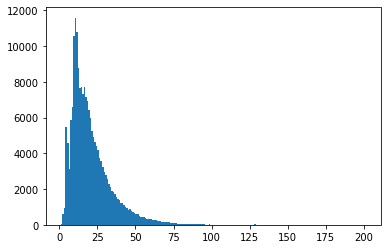

In [33]:
# plot histogram for the number of characters
num_bins = 200
n, bins, patches = plt.hist(summary_length, num_bins)
print(stats.describe(summary_length))
plt.show()

In [34]:
# sentiment analysis for positive and negative words in the summary text

# import positive and negative word lists
posWords_list = [x.strip() for x in open("positive-words.txt", "r").readlines()]
negWords_list = [x.strip() for x in open("negative-words.txt", "r", encoding="ISO-8859-1").readlines()]

# count the number of positive and negative words present in each review text
pos_neg_count = []
for k,i in zip(df.index,df.summary):
#     print(k)
    words = [n.lower().translate(str.maketrans('','',string.punctuation)) for n in i.split(' ')]
    pos_count = 0
    neg_count = 0
    for j in words:
        if j in posWords_list:
            pos_count+=1
        elif j in negWords_list:
            neg_count+=1
        else: 
            continue
    pos_neg_count.append((pos_count, neg_count))

DescribeResult(nobs=200000, minmax=(0, 8), mean=0.804635, variance=0.46882986092430456, skewness=0.7537723207309887, kurtosis=1.5160464591534257)


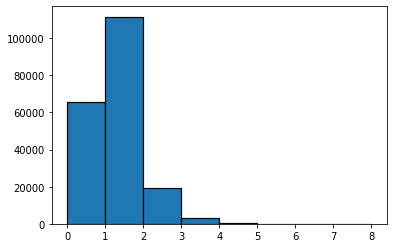

DescribeResult(nobs=200000, minmax=(0, 6), mean=0.090745, variance=0.09548082237911189, skewness=3.6305959777821135, kurtosis=15.150528659906936)


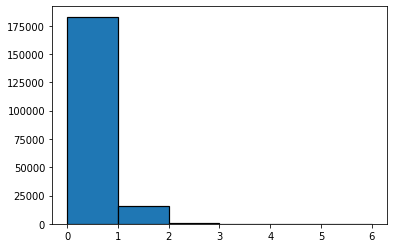

In [35]:
# see distribution of positive and negative word mentions

pos_count_list = [i[0] for i in pos_neg_count]
neg_count_list = [i[1] for i in pos_neg_count]

num_bins = 8
n, bins, patches = plt.hist(pos_count_list, num_bins, linewidth=1.2, edgecolor='black')
print(stats.describe(pos_count_list))
plt.show()

num_bins = 6
n, bins, patches = plt.hist(neg_count_list, num_bins, linewidth=1.2, edgecolor='black')
print(stats.describe(neg_count_list))
plt.show()

In [36]:
# find the positive and negative word rate

# count the number of words in each review
word_count = []
for i in df.summary:
    words = [n.lower().translate(str.maketrans('','',string.punctuation)) for n in i.split(' ')]
    words = [i for i in words if i != ''] # remove spaces
    word_count.append(len(words))

DescribeResult(nobs=200000, minmax=(0, 31), mean=3.618705, variance=6.381171028830144, skewness=2.0615077494265237, kurtosis=7.203003750824742)


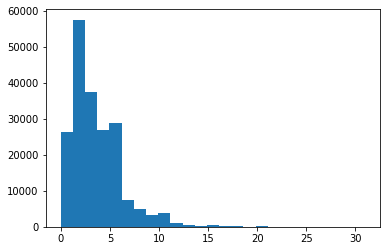

In [43]:
# see distribution of number of words for each review
num_bins = 25
n, bins, patches = plt.hist(word_count, num_bins)
print(stats.describe(word_count))
plt.show()

In [44]:
# find rate for pos and neg, assign zero when no words are present in review
# rate is defined as the number of pos or neg words divided by the total number of words for the review

pos_count_rate = [0 if j == 0 else i/j for i,j in zip(pos_count_list, word_count)]
print(stats.describe(pos_count_rate))
neg_count_rate = [0 if j == 0 else i/j for i,j in zip(neg_count_list, word_count)]
print(stats.describe(pos_count_rate))

DescribeResult(nobs=200000, minmax=(0.0, 1.0), mean=0.3061511954570784, variance=0.09228970800382653, skewness=0.897785089479258, kurtosis=0.0635350595052393)
DescribeResult(nobs=200000, minmax=(0.0, 1.0), mean=0.3061511954570784, variance=0.09228970800382653, skewness=0.897785089479258, kurtosis=0.0635350595052393)


### unixReviewTime

In [47]:
# find the number of different unixReviewTime
print(len(set(df.unixReviewTime)))

2532


In [54]:
# find min and max with stats describe
print(stats.describe(df.unixReviewTime))

DescribeResult(nobs=200000, minmax=(1048896000, 1406073600), mean=1374645654.432, variance=814365023822719.4, skewness=-2.501333904069944, kurtosis=10.114889725162536)


In [48]:
# find number of times each unixReviewTime shows up
items_dict = {i:0 for i in set(df.unixReviewTime)}
for i in df.unixReviewTime:
    items_dict[i]+=1

{k: v for k, v in sorted(items_dict.items(), key=lambda item: item[1], reverse=True)}

{1388016000: 680,
 1388448000: 608,
 1389225600: 597,
 1388707200: 588,
 1386633600: 587,
 1389139200: 579,
 1388620800: 571,
 1404691200: 553,
 1404864000: 548,
 1405036800: 547,
 1386806400: 546,
 1392681600: 544,
 1389052800: 541,
 1386720000: 533,
 1405123200: 530,
 1389744000: 521,
 1386028800: 521,
 1388102400: 515,
 1388966400: 505,
 1389657600: 500,
 1389830400: 499,
 1394064000: 496,
 1387238400: 494,
 1389571200: 494,
 1392076800: 492,
 1394496000: 482,
 1395878400: 481,
 1392940800: 478,
 1386288000: 476,
 1383004800: 476,
 1388361600: 476,
 1394409600: 475,
 1389312000: 475,
 1390348800: 473,
 1387324800: 472,
 1404950400: 469,
 1404777600: 468,
 1400112000: 467,
 1393372800: 466,
 1390262400: 466,
 1384992000: 465,
 1384905600: 465,
 1385942400: 463,
 1393286400: 463,
 1391731200: 461,
 1393891200: 460,
 1391558400: 458,
 1396483200: 457,
 1392163200: 457,
 1390867200: 457,
 1398729600: 455,
 1386547200: 454,
 1395273600: 453,
 1387152000: 450,
 1397692800: 449,
 139432320

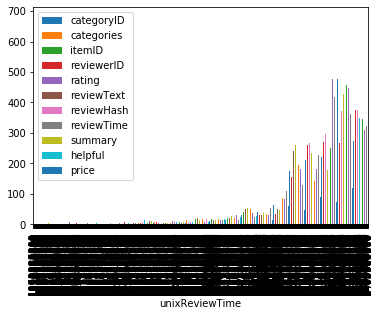

In [53]:
# plot histogram of sorted unit review time (increasing)
df.groupby(df["unixReviewTime"]).count().sort_index().plot(kind="bar")

### helpful

In [5]:
# parse outOf and nHelpful for each review to understand the distribution
outOf_list = [i['outOf'] for i in df.helpful]
nHelpful_list = [i['nHelpful'] for i in df.helpful]

In [20]:
len(outOf_list)

200000

In [19]:
# find number frequency 
votes_count_dict = {k:0 for k in set(outOf_list)}

for i in outOf_list:
    votes_count_dict[i]+=1
    
{k: v for k, v in sorted(votes_count_dict.items(), key=lambda item: item[1], reverse=True)}

{0: 136984,
 1: 28551,
 2: 12022,
 3: 5859,
 4: 4104,
 5: 2489,
 6: 1618,
 7: 1291,
 8: 1015,
 9: 751,
 10: 647,
 11: 476,
 12: 452,
 13: 362,
 14: 299,
 15: 265,
 16: 249,
 17: 238,
 19: 175,
 18: 163,
 21: 148,
 22: 125,
 20: 122,
 24: 111,
 25: 97,
 23: 95,
 26: 78,
 29: 78,
 28: 59,
 27: 58,
 31: 58,
 30: 53,
 33: 50,
 34: 46,
 32: 43,
 37: 37,
 36: 32,
 39: 30,
 41: 28,
 35: 27,
 38: 27,
 40: 27,
 42: 25,
 48: 24,
 43: 21,
 44: 21,
 49: 21,
 47: 20,
 46: 18,
 54: 18,
 53: 14,
 56: 14,
 58: 14,
 55: 13,
 50: 12,
 45: 11,
 61: 11,
 62: 11,
 51: 10,
 52: 10,
 67: 10,
 75: 10,
 65: 9,
 84: 8,
 57: 7,
 59: 7,
 63: 7,
 82: 7,
 60: 6,
 64: 6,
 66: 6,
 77: 6,
 69: 5,
 92: 5,
 98: 5,
 68: 4,
 70: 4,
 79: 4,
 81: 4,
 89: 4,
 71: 3,
 72: 3,
 73: 3,
 74: 3,
 87: 3,
 93: 3,
 96: 3,
 97: 3,
 101: 3,
 102: 3,
 103: 3,
 106: 3,
 112: 3,
 118: 3,
 134: 3,
 76: 2,
 78: 2,
 83: 2,
 85: 2,
 86: 2,
 88: 2,
 91: 2,
 95: 2,
 99: 2,
 104: 2,
 107: 2,
 111: 2,
 116: 2,
 120: 2,
 121: 2,
 124: 2,
 125: 2,


In [25]:
# find number frequency percentage
votes_perc_dict = {k:0 for k in set(outOf_list)}
for i in set(outOf_list):
    votes_perc_dict[i] = 100*votes_count_dict[i]/len(outOf_list)

{k: v for k, v in sorted(votes_perc_dict.items(), key=lambda item: item[1], reverse=True)}

{0: 68.492,
 1: 14.2755,
 2: 6.011,
 3: 2.9295,
 4: 2.052,
 5: 1.2445,
 6: 0.809,
 7: 0.6455,
 8: 0.5075,
 9: 0.3755,
 10: 0.3235,
 11: 0.238,
 12: 0.226,
 13: 0.181,
 14: 0.1495,
 15: 0.1325,
 16: 0.1245,
 17: 0.119,
 19: 0.0875,
 18: 0.0815,
 21: 0.074,
 22: 0.0625,
 20: 0.061,
 24: 0.0555,
 25: 0.0485,
 23: 0.0475,
 26: 0.039,
 29: 0.039,
 28: 0.0295,
 27: 0.029,
 31: 0.029,
 30: 0.0265,
 33: 0.025,
 34: 0.023,
 32: 0.0215,
 37: 0.0185,
 36: 0.016,
 39: 0.015,
 41: 0.014,
 35: 0.0135,
 38: 0.0135,
 40: 0.0135,
 42: 0.0125,
 48: 0.012,
 43: 0.0105,
 44: 0.0105,
 49: 0.0105,
 47: 0.01,
 46: 0.009,
 54: 0.009,
 53: 0.007,
 56: 0.007,
 58: 0.007,
 55: 0.0065,
 50: 0.006,
 45: 0.0055,
 61: 0.0055,
 62: 0.0055,
 51: 0.005,
 52: 0.005,
 67: 0.005,
 75: 0.005,
 65: 0.0045,
 84: 0.004,
 57: 0.0035,
 59: 0.0035,
 63: 0.0035,
 82: 0.0035,
 60: 0.003,
 64: 0.003,
 66: 0.003,
 77: 0.003,
 69: 0.0025,
 92: 0.0025,
 98: 0.0025,
 68: 0.002,
 70: 0.002,
 79: 0.002,
 81: 0.002,
 89: 0.002,
 71: 0.001

In [84]:
# count number of reviewe where helpful is zero
np.sum(np.array(nHelpful_list)==0)

144962

In [85]:
# count number of reviews where both are zero
np.sum((np.array(nHelpful_list)==0) & (np.array(outOf_list)==0))

136984

In [33]:
# remove votes that are zero
from itertools import compress

outOf_list_filt = list(compress(outOf_list, (np.array(outOf_list)>50) & (np.array(outOf_list)<1000)))
nHelpful_list_filt = list(compress(nHelpful_list, (np.array(nHelpful_list)>50) & (np.array(nHelpful_list)<1000)))

DescribeResult(nobs=388, minmax=(51, 537), mean=97.98195876288659, variance=5113.330423026719, skewness=3.0642265609303463, kurtosis=10.919909645893389)


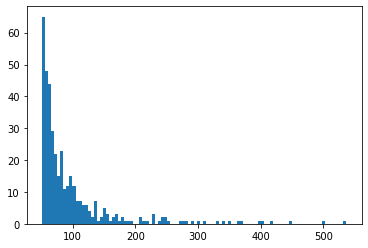

DescribeResult(nobs=341, minmax=(51, 520), mean=97.27859237536657, variance=4911.04274624806, skewness=2.9505276009529298, kurtosis=9.892588845433826)


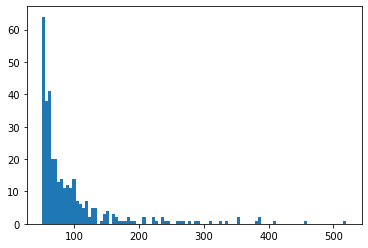

In [34]:
num_bins = 100
n, bins, patches = plt.hist(outOf_list_filt, num_bins)
print(stats.describe(outOf_list_filt))
plt.show()

num_bins = 100
n, bins, patches = plt.hist(nHelpful_list_filt, num_bins)
print(stats.describe(nHelpful_list_filt))
plt.show()

### price

In [97]:
# find the number of na values
sum(df.price.isna())

125851

In [98]:
# find the number of non-na values
sum(~df.price.isna())

74149

DescribeResult(nobs=74149, minmax=(0.01, 999.0), mean=24.688777461597596, variance=991.18208864537, skewness=6.056005293547956, kurtosis=89.32970933289522)


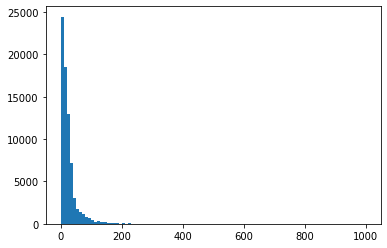

In [99]:
# plot distribution of prices
num_bins = 100
n, bins, patches = plt.hist(df.price[~df.price.isna()], num_bins)
print(stats.describe(df.price[~df.price.isna()]))
plt.show()

In [41]:
test_df.head()

,categoryID,categories,itemID,reviewerID,rating,reviewText,reviewHash,reviewTime,summary,unixReviewTime,helpful,price
0,0,"[[Sports & Outdoors, Other Sports, Dance, Clot...",I520932398,U816789534,3.0,I ordered according to the size chart but it's...,R157684793,"07 15, 2011",Too small,1310688000,{'outOf': 2},NaN
1,0,"[[Sports & Outdoors, Clothing, Women, Hoodies]...",I969532331,U987148846,4.0,Super thin but really cute and not cheap-looki...,R732719858,"07 17, 2013",Fun hoodie,1374019200,{'outOf': 0},NaN
2,0,"[[Clothing, Shoes & Jewelry, Women, Accessorie...",I149943341,U628436634,5.0,"It was a present for my sis, and she loves Fle...",R352659313,"12 8, 2013",A Perfect hook up,1386460800,{'outOf': 1},NaN
3,0,"[[Clothing, Shoes & Jewelry, Women, Accessorie...",I909025835,U924107228,5.0,I love this thing! I guess they don't make th...,R277416618,"11 22, 2012",I love this thing...,1353542400,{'outOf': 1},7.51
4,0,"[[Clothing, Shoes & Jewelry, Women, Clothing, ...",I228439768,U060135484,4.0,I liked it and I wear it...it's a little bit s...,R645892076,"04 1, 2014",I liked it...,1396310400,{'outOf': 0},NaN
